<a href="https://colab.research.google.com/github/Albertyao1993/Albertyao1993.github.io/blob/master/DistilBert_CN1_Multi_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 简介
- distil bert
- no cross validation
- no semantic loss

In [1]:
!pip install transformers Ipython


     |████████████████████████████████| 3.4 MB 8.7 MB/s 
     |████████████████████████████████| 3.3 MB 65.4 MB/s 
     |████████████████████████████████| 67 kB 6.1 MB/s 
     |████████████████████████████████| 596 kB 78.2 MB/s 
     |████████████████████████████████| 895 kB 71.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import transformers

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import AdamW
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import softmax
from torch.nn.utils import clip_grad_norm_
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from collections import defaultdict

RANDOM_STATE = 42
BATCH_SIZE = 32
EPOCH = 20
LR = 2e-5
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL_NAME = 'distilbert-base-uncased'

class CN1_Dataset(Dataset):

    def __init__(self,data, max_len=256):
        self.data = data
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        self.max_len = max_len
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        row_data = self.data.iloc[idx]
        content = row_data['content']
        label = row_data[-3:]

        encoding = self.tokenizer(
            content,
            padding='max_length', 
            truncation=True,
            max_length=self.max_len, 
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.float32)
        }

def CreateDataloader(ds, batch_size=16, drop_last=False):
    return DataLoader(
        ds,
        batch_size=batch_size,
        drop_last=drop_last
    )

def semantic_loss(preds, batch_size, device):

    normalized_preds = torch.sigmoid(preds).to(device)
    # print(normalized_preds)
    wmc_tmp = torch.zeros(n_batch_size).to(device)
    for i in range(3):
        one = torch.concat(
            [torch.concat([torch.ones([n_batch_size,i]), torch.zeros([n_batch_size, 1])], axis=1),
             torch.ones([n_batch_size, 3-i-1])], axis=1).to(device)
        # normalized_preds = torch.stack((normalized_preds,normalized_preds,normalized_preds),1)
        # print(normalized_preds)
        # break
        # print(one - normalized_preds)
        # print('--------------------------')
        # wmc_tmp += torch.prod(one-preds, axis=1).to(device)
        wmc_tmp += torch.prod(one-normalized_preds, axis=1).to(device)
        # print(torch.log(torch.abs(wmc_tmp)))
        log_wmc = (torch.abs(wmc_tmp)).to(device)
        sl = torch.mean(torch.sum(log_wmc)).to(device)
    return sl

'''
load data
'''
df = pd.read_csv('/content/drive/Othercomputers/我的 MacBook Pro (1)/Documents/GitHub/neural_symbolic_FG/training/kn1_data.csv')
df_data = pd.DataFrame()
df_data['content'] = df['reference_answer'] + df['response']
one_hot_labels = pd.get_dummies(df['verification'])
df_data = pd.concat([df_data, one_hot_labels], axis=1)

'''
create train and val dataset and dataloader
'''
df_train,df_val = train_test_split(df_data, random_state=RANDOM_STATE, test_size=0.15)
ds_train = CN1_Dataset(df_train)
ds_val = CN1_Dataset(df_val)

dl_train = CreateDataloader(ds_train,batch_size=BATCH_SIZE)
dl_val = CreateDataloader(ds_val, batch_size=BATCH_SIZE)

model = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME,
                                                            num_labels=3,
                                                            output_hidden_states=False,
                                                            output_attentions=False)
model.to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = AdamW(model.parameters(), lr=LR )

history = defaultdict(list)

for epoch in range(EPOCH):


    model.train()
    train_losses = []
    train_correct_preds = 0

    for data in dl_train:
        input_ids = data['input_ids'].squeeze(1).to(DEVICE)
        attention_mask = data['attention_mask'].squeeze(1).to(DEVICE)
        label = data['label'].to(DEVICE)

        output = model(input_ids, attention_mask)
        output = softmax(output.logits)

        train_loss = criterion(output, label)
        train_losses.append(train_loss.item())
        train_correct_preds += torch.sum(torch.argmax(output, dim=1) == torch.argmax(label, dim=1))
        train_acc = train_correct_preds / len(ds_train)

        train_loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()


    model.eval()
    val_losses = []
    val_correct_preds = 0
    with torch.no_grad():
      for data in dl_val:
          input_ids = data['input_ids'].squeeze(1).to(DEVICE)
          attention_mask = data['attention_mask'].squeeze(1).to(DEVICE)
          label = data['label'].to(DEVICE)

          output = model(input_ids, attention_mask)
          output = softmax(output.logits)

          val_loss = criterion(output, label)
          val_losses.append(val_loss.item())
          val_correct_preds += torch.sum(torch.argmax(output, dim=1) == torch.argmax(label, dim=1))
          val_acc = val_correct_preds / len(ds_val)
    
    
    history['train_loss'].append(np.mean(train_losses))
    history['train_acc'].append(train_acc)
    history['val_loss'].append(np.mean(val_losses))
    history['val_acc'].append(val_acc)

    print('#'*50)
    print(f'run {epoch+1} of {EPOCH}')
    print(f'train loss: {np.mean(train_losses)}, train acc: {train_acc}')
    print(f'val loss: {np.mean(val_losses)}, val acc: {val_acc}')





Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classi

##################################################
run 1 of 20
train loss: 1.006522063910961, train acc: 0.5582137107849121
val loss: 0.9454509445599147, val acc: 0.6081081032752991
##################################################
run 2 of 20
train loss: 0.9171359434723854, train acc: 0.6379585266113281
val loss: 0.9039883613586426, val acc: 0.6486486792564392
##################################################
run 3 of 20
train loss: 0.8956345304846763, train acc: 0.6459330320358276
val loss: 0.9069046889032636, val acc: 0.639639675617218
##################################################
run 4 of 20
train loss: 0.8898771524429321, train acc: 0.6531100273132324
val loss: 0.8956801976476397, val acc: 0.6441441774368286
##################################################
run 5 of 20
train loss: 0.8780630648136138, train acc: 0.6658692359924316
val loss: 0.8850364259311131, val acc: 0.662162184715271
##################################################
run 6 of 20
train loss: 0.85854168236

# Plot train loss and accuracy


(0.0, 1.0)

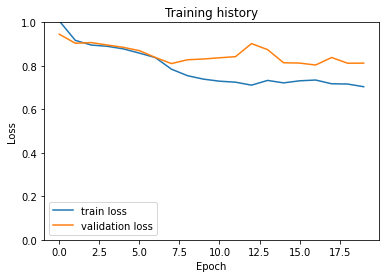

In [3]:
import matplotlib.pyplot as plt

plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

(0.0, 1.0)

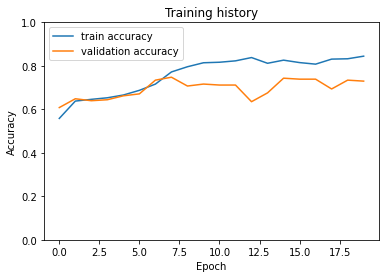

In [4]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])